In [1]:
import numpy as np
from numpy.polynomial import polynomial as P
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import norm, t
np.random.seed(42)

In [2]:
def generate_H0_data(n, turning, intercept,
                     slope_left, slope_right, error_term):
    x_left = np.linspace(turning-1, turning, n)
    x_right = np.linspace(turning, turning+1, n)
    x = np.hstack((x_left, x_right))
    y_left = intercept + slope_left*x_left + error_term*np.random.randn(n)
    y_right = intercept + slope_right*x_right + error_term*np.random.randn(n)
    y = np.hstack((y_left, y_right))
    return x, y

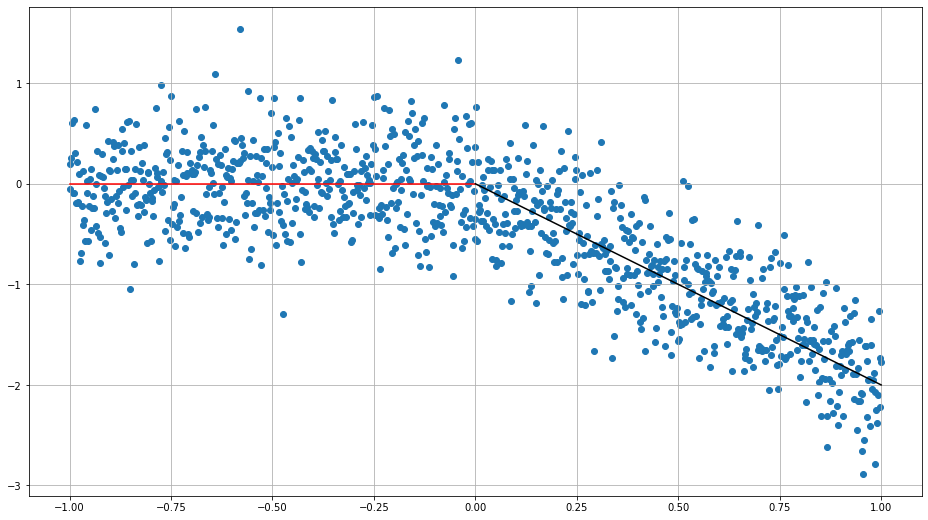

In [3]:
x, y = generate_H0_data(n=500, turning=0, intercept=0, slope_left=0, slope_right=-2, error_term=0.4)
plt.figure(figsize=(16,9))
plt.scatter(x, y)
plt.plot([x[0], x[499]], [0-0*x[0], 0-0*x[499]], "r")
plt.plot([x[499], x[-1]], [0-2*x[499], 0-2*x[-1]], "k")
plt.grid()
plt.show()

In [4]:
class peak_slope_sign():
    def __init__(self, x, y, epsilon, region, turning=0):
        self.turning = turning
        self.x = x
        self.y = y
        self.epsilon = epsilon
        self.region = region
        self.demarcation_index = np.where((self.x > self.turning-self.epsilon) & (self.x < self.turning+self.epsilon))[0]
        
        self.intercept_left_list, self.slope_left_list = [], []
        self.intercept_right_list, self.slope_right_list =[], []
    
    def demarcation_slope_product(self):
        if not self.slope_left_list:
            for i in self.demarcation_index:
                start_index = np.where(self.x > self.x[i]-self.region)[0][0]
                end_index = np.where(self.x < self.x[i]+self.region)[0][-1]
                coef_left = P.polyfit(x=self.x[start_index:i],
                                    y=self.y[start_index:i],
                                    deg=1)
                coef_right = P.polyfit(x=self.x[i:end_index],
                                    y=self.y[i:end_index],
                                    deg=1)
                self.intercept_left_list.append(coef_left[0])
                self.intercept_right_list.append(coef_right[0])
                self.slope_left_list.append(coef_left[1])
                self.slope_right_list.append(coef_right[1])
        return np.array(self.slope_left_list) * np.array(self.slope_right_list)
    
    def scatter_reg_plot(self, i_th):
        start_index = np.where(self.x > self.x[self.demarcation_index[i_th]]-self.region)[0][0]
        end_index = np.where(self.x < self.x[self.demarcation_index[i_th]]+self.region)[0][-1]

        plt.figure(figsize=(16, 9))
        plt.scatter(self.x, self.y, c="y", s=15)

        plt.plot(self.x[start_index:self.demarcation_index[i_th]],
                 np.array(self.intercept_left_list[i_th]) + \
                 np.array(self.slope_left_list[i_th])*self.x[start_index:self.demarcation_index[i_th]], "r")
        
        plt.plot(self.x[self.demarcation_index[i_th]:end_index],
                 np.array(self.intercept_right_list[i_th]) + \
                 np.array(self.slope_right_list[i_th])*self.x[self.demarcation_index[i_th]:end_index], "k")
        plt.grid()
        plt.show()
    
    def test_peak(self, i_th):
        X = sm.add_constant(self.x)
        Y = self.y
        start_index = np.where(self.x > self.x[self.demarcation_index[i_th]]-self.region)[0][0]
        end_index = np.where(self.x < self.x[self.demarcation_index[i_th]]+self.region)[0][-1]

        mod_left = sm.OLS(Y[start_index:self.demarcation_index[i_th]],
                          X[start_index:self.demarcation_index[i_th]])
        res_left = mod_left.fit()

        mod_right = sm.OLS(Y[self.demarcation_index[i_th]:end_index],
                           X[self.demarcation_index[i_th]:end_index])
        res_right = mod_right.fit()

        left_pvalue = 1 - t.cdf(res_left.tvalues[-1], df=end_index-self.demarcation_index[i_th]-2)
        right_pvalue = t.cdf(res_right.tvalues[-1], df=self.demarcation_index[i_th]-start_index-2)

        return {"beta1_hat":round(res_left.params[1],5),
                "Left t-statistic":round(res_left.tvalues[-1],5),
                "Left p-value":round(left_pvalue,5),
                "beta2_hat":round(res_right.params[1],5),
                "Right t-statistic":round(res_right.tvalues[-1],5),
                "Right p-value":round(right_pvalue,5)}
                
    def test_valley(self, i_th):
        X = sm.add_constant(self.x)
        Y = self.y
        start_index = np.where(self.x > self.x[self.demarcation_index[i_th]]-self.region)[0][0]
        end_index = np.where(self.x < self.x[self.demarcation_index[i_th]]+self.region)[0][-1]

        mod_left = sm.OLS(Y[start_index:self.demarcation_index[i_th]],
                          X[start_index:self.demarcation_index[i_th]])
        res_left = mod_left.fit()

        mod_right = sm.OLS(Y[self.demarcation_index[i_th]:end_index],
                           X[self.demarcation_index[i_th]:end_index])
        res_right = mod_right.fit()

        left_pvalue = t.cdf(res_left.tvalues[-1], df=end_index-self.demarcation_index[i_th]-2)
        right_pvalue = 1 - t.cdf(res_right.tvalues[-1], df=self.demarcation_index[i_th]-start_index-2)

        return {"beta1_hat":round(res_left.params[1],5),
                "Left t-statistic":round(res_left.tvalues[-1],5),
                "Left p-value":round(left_pvalue,5),
                "beta2_hat":round(res_right.params[1],5),
                "Right t-statistic":round(res_right.tvalues[-1],5),
                "Right p-value":round(right_pvalue,5)}

## 取範圍0.2

In [5]:
test1 = peak_slope_sign(x=x, y=y, turning=0, epsilon=0.1, region=0.2)
print(test1.demarcation_index.shape)

(100,)


In [6]:
#test1.demarcation_slope_product()

In [7]:
np.where(test1.demarcation_slope_product() < 0)[0]

array([29, 30, 31, 45], dtype=int64)

In [8]:
for i in np.where(test1.demarcation_slope_product() < 0)[0]:
    print(test1.test_peak(i), "\n")

{'beta1_hat': 0.1646, 'Left t-statistic': 0.21474, 'Left p-value': 0.41521, 'beta2_hat': -1.65806, 'Right t-statistic': -2.45483, 'Right p-value': 0.00794} 

{'beta1_hat': 0.20301, 'Left t-statistic': 0.26419, 'Left p-value': 0.39609, 'beta2_hat': -1.36129, 'Right t-statistic': -2.01668, 'Right p-value': 0.02325} 

{'beta1_hat': 0.11535, 'Left t-statistic': 0.15029, 'Left p-value': 0.44042, 'beta2_hat': -1.31244, 'Right t-statistic': -1.94363, 'Right p-value': 0.02742} 

{'beta1_hat': 0.02008, 'Left t-statistic': 0.02633, 'Left p-value': 0.48953, 'beta2_hat': -0.89171, 'Right t-statistic': -1.38826, 'Right p-value': 0.08412} 



In [9]:
for i in range(0, 100, 5):
    print(test1.test_peak(i), "\n")

{'beta1_hat': -0.95246, 'Left t-statistic': -1.31631, 'Left p-value': 0.90443, 'beta2_hat': -1.67005, 'Right t-statistic': -2.39111, 'Right p-value': 0.00936} 

{'beta1_hat': -0.88562, 'Left t-statistic': -1.23067, 'Left p-value': 0.8893, 'beta2_hat': -1.43906, 'Right t-statistic': -2.06359, 'Right p-value': 0.02086} 

{'beta1_hat': -1.41775, 'Left t-statistic': -1.96961, 'Left p-value': 0.97415, 'beta2_hat': -2.03803, 'Right t-statistic': -2.98472, 'Right p-value': 0.0018} 

{'beta1_hat': -1.00637, 'Left t-statistic': -1.37606, 'Left p-value': 0.91403, 'beta2_hat': -1.36931, 'Right t-statistic': -1.97, 'Right p-value': 0.02584} 

{'beta1_hat': -1.06775, 'Left t-statistic': -1.45526, 'Left p-value': 0.9256, 'beta2_hat': -2.03734, 'Right t-statistic': -2.84298, 'Right p-value': 0.00272} 

{'beta1_hat': -0.63614, 'Left t-statistic': -0.84688, 'Left p-value': 0.80044, 'beta2_hat': -1.82595, 'Right t-statistic': -2.65788, 'Right p-value': 0.0046} 

{'beta1_hat': 0.20301, 'Left t-statistic'

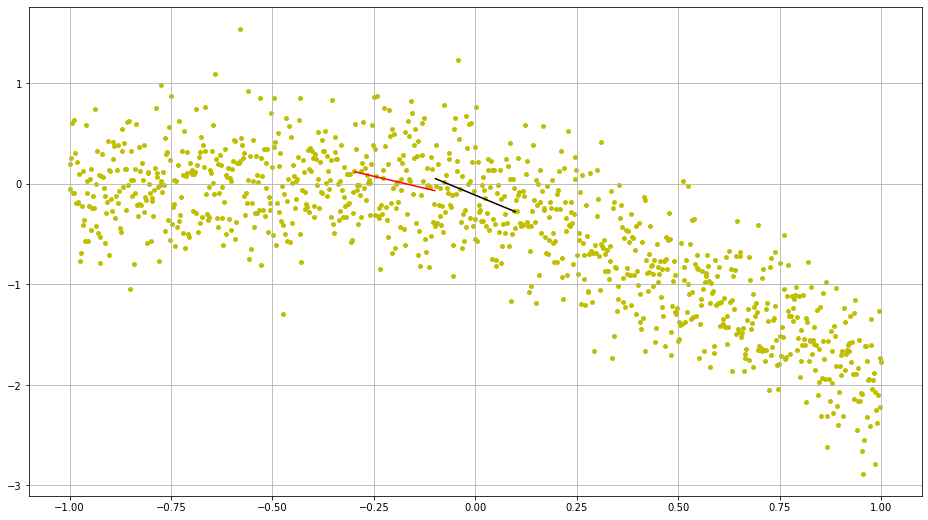

In [10]:
test1.scatter_reg_plot(0)

In [11]:
test1.test_peak(0)

{'beta1_hat': -0.95246,
 'Left t-statistic': -1.31631,
 'Left p-value': 0.90443,
 'beta2_hat': -1.67005,
 'Right t-statistic': -2.39111,
 'Right p-value': 0.00936}